In [52]:
def construir_grafo_cursos(examenes):
    calendario = Graph(len(list(examenes.keys())))
    for e in calendario.vertices():
        for e2 in calendario.vertices()[e + 1:]:
            w = len(set(examenes[e]) & set(examenes[e2]))
            if w:
                calendario.add_edge((e, e2, w))
    return calendario

In [53]:
def iniciacion_limites_concurrencias(dias, slots, concurrencias_maximas):
    limites_concurrencias = {}
    for dia in range(dias):
        for slot in range(slots):
            limites_concurrencias[(dia, slot)] = concurrencias_maximas
    return limites_concurrencias

In [54]:
def obtener_primer_color(curso, dias, slots, limites_concurrencias, concurrencias):
    color = (0, 0)  # Define un color como combinación de día y horario.
    if limites_concurrencias[color] >= concurrencias[curso]:
        # Verifica si el color tiene capacidad suficiente para este curso.
        return color  # Devuelve el color válido encontrado.
    return None  # Devuelve `None` si no hay colores válidos.

In [55]:
def obtener_menor_color_disponible(calendario, cursos, curso, colores, dias, slots, limites_concurrencias, concurrencias):
    grados = calendario.degree()
    matriz_pesos = calendario.weighted_adjacency_matrix()
    lista_adyacencia = sorted(calendario.neighbors(curso), key=lambda node: (-grados[node], -max(matriz_pesos[node]), node))
    for dia in range(dias):  # Itera sobre los días posibles.
        for slot in range(slots):  # Itera sobre los horarios posibles.
            color = (dia, slot)  # Define un color como combinación de día y horario.
            if limites_concurrencias[color] >= concurrencias[curso]:
                if not lista_adyacencia:
                    return color
                else:
                    coloreados = [vecino for vecino in lista_adyacencia if vecino in colores]
                    if all([colores[vecino] != color and 
                            es_valido(color, curso, vecino, colores, dias, cursos) for vecino in coloreados]):
                        return color                    
    return None
                    

In [56]:
def es_valido(color, curso, vecino, colores, dias, cursos):
    dia_actual, slot_actual = color
    estudiantes_curso = cursos[curso]
    estudiantes_vecino = cursos[vecino]

    # Restricción 1: No permitir exámenes consecutivos en el mismo día.
    color_vecino = colores[vecino]
    dia_vecino, slot_vecino = color_vecino
    if dia_actual == dia_vecino and abs(slot_actual - slot_vecino) <= 1:
        return False

    # Restricción 2: No permitir más de dos exámenes al día por estudiante.                
    colores_dias = {c : (dia, slot) for (c, (dia, slot)) in list(colores.items()) if dia == dia_actual and c != curso}
    if colores_dias:
        for estudiante in cursos[curso]:
            coincidencias = 0
            for c in colores_dias:
                if estudiante in cursos[c]:
                    coincidencias += 1
                if coincidencias == 2:
                    return False
                
    return True



In [57]:
def algoritmo_coloracion_calendario(cursos, slots, dias, limites_concurrencias, concurrencia_maxima):
    # Paso 1: Construcción del grafo
    grafo = construir_grafo_cursos(cursos)
    grados = grafo.degree()
    matriz_pesos = grafo.weighted_adjacency_matrix()
    
            
    
    # Paso 2: Ordenar nodos
    cursos_ordenados =  sorted(cursos, key=lambda node: (-grados[node], -max(matriz_pesos[node]), node))
    # `cursos_ordenados` es una lista de los nodos ordenados por prioridad:
    # 1. Mayor grado (número de conexiones).
    # 2. Mayor peso en la lista de adyacencia.
    # 3. Menor ID (en caso de empate).

    # Variables iniciales
    num_cursos_coloreados = 0  # Contador de cursos que ya tienen un color asignado.
    colores = {}  # Diccionario que almacena el color asignado a cada curso.
    limites_concurrencias = iniciacion_limites_concurrencias(dias, slots, concurrencia_maxima)
    # `limites_concurrencias` define cuántas veces puede usarse un color (basado en los recursos disponibles).

    # Paso 3: Asignar colores
    cont = 0
    for curso in cursos_ordenados:  # Itera sobre cada nodo del grafo (en orden de prioridad).
        if curso not in colores:
            if cont == 0:  # Si el curso aún no tiene color asignado.
                color = obtener_primer_color(curso, dias, slots, limites_concurrencias, concurrencias)
                # Intenta obtener el primer color disponible para el nodo.
                if color is None:  # Si no hay colores válidos disponibles, no se puede programar.
                    return "No es posible programar"
                colores[curso] = color  # Asigna el color encontrado al curso.
                num_cursos_coloreados += 1  # Incrementa el contador de cursos coloreados.
                limites_concurrencias[color] -= concurrencias[curso]
                cont += 1
                # Reduce el límite de concurrencia del color, teniendo en cuenta los recursos usados por este curso.
            else:
                color = obtener_menor_color_disponible(
                        grafo, cursos, curso, colores, dias, slots, limites_concurrencias, concurrencias)
                if color is None:
                      return "No es posible programar"
                colores[curso] = color  # Asigna el color al nodo adyacente.
                num_cursos_coloreados += 1  # Incrementa el contador de cursos coloreados.
                limites_concurrencias[color] -= concurrencias[curso]

            lista_adyacencia = sorted(grafo.neighbors(curso), key=lambda node: (-grados[node], -max(matriz_pesos[node]), node))
            # `lista_adyacencia` contiene los cursos conectados al curso actual (nodos adyacentes).
            for vecino in lista_adyacencia:  # Itera sobre los nodos adyacentes.
                if vecino not in colores.keys():  # Si el nodo adyacente no está coloreado.
                    color_vecino = obtener_menor_color_disponible(
                         grafo, cursos, vecino, colores, dias, slots, limites_concurrencias, concurrencias)
                    # Intenta obtener el color más pequeño disponible que respete las restricciones.
                    if color_vecino:  # Si se encuentra un color válido.
                        colores[vecino] = color_vecino  # Asigna el color al nodo adyacente.
                        num_cursos_coloreados += 1  # Incrementa el contador de cursos coloreados.
                        limites_concurrencias[color_vecino] -= concurrencias[vecino]
                        # Reduce el límite de concurrencia para el color dado en función de los recursos usados.
                    else:
                        return "No es posible programar"
    return colores  # Devuelve el diccionario con los colores asignados a cada curso.

In [67]:
num_estudiantes = 15
estudiantes = [f"Estudiante{i}" for i in range(1, num_estudiantes + 1)]

# Generar cursos y asignar estudiantes
cursos = {
    0: ['Estudiante1','Estudiante2','Estudiante3','Estudiante6'],
    1: ['Estudiante1','Estudiante4','Estudiante7'],
    2: ['Estudiante3','Estudiante4','Estudiante8'],
    3: ['Estudiante2','Estudiante8'],
    4: ['Estudiante6'],
    5: ['Estudiante7']
}

# Parámetros generales
slots = 6 # Horarios por día
dias = 1  # Días disponibles
concurrencia_maxima = 2  # Capacidad total por slot

# Calcular concurrencias (número de estudiantes por curso)
concurrencias = {curso: 1 for curso in cursos}

# Imprimir datos generados
print("Cursos y estudiantes inscritos:")
for curso, estudiantes in cursos.items():
    print(f"{curso}: {estudiantes}")

print("\nConcurrencias:")
print(concurrencias)

print("\nParámetros:")
print(f"Slots: {slots}")
print(f"Días: {dias}")
print(f"Concurrencia máxima: {concurrencia_maxima}")

resultado = algoritmo_coloracion_calendario(cursos,slots,dias,concurrencias,concurrencia_maxima)

print(resultado)

Cursos y estudiantes inscritos:
0: ['Estudiante1', 'Estudiante2', 'Estudiante3', 'Estudiante6']
1: ['Estudiante1', 'Estudiante4', 'Estudiante7']
2: ['Estudiante3', 'Estudiante4', 'Estudiante8']
3: ['Estudiante2', 'Estudiante8']
4: ['Estudiante6']
5: ['Estudiante7']

Concurrencias:
{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1}

Parámetros:
Slots: 6
Días: 1
Concurrencia máxima: 2
{0: (0, 0), 1: (0, 2), 2: (0, 4), 3: (0, 2), 4: (0, 3), 5: (0, 0)}


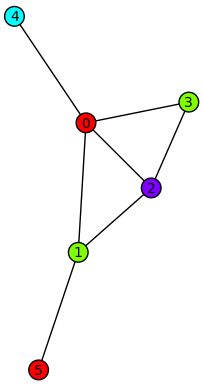

In [68]:
calendario = construir_grafo_cursos(cursos)
coloracion = {}
particiones = sorted(list(set(resultado.values())), key = lambda r : (slots - 1) * r[1] + r[0]) # Ordena los colores por el peso 
colores_disponibles = rainbow(len(particiones))
for (c, p) in zip(colores_disponibles, particiones):
    coloracion[c] = [curso for curso in cursos if resultado[curso] == p]
coloracion
calendario.plot(vertex_colors = coloracion)